# Covid_19 Swiss Data Analysis

In [22]:
#Step
import warnings
import math
from scipy import stats
import pandas as pd
from datetime import date, datetime
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style="ticks")
sns.set_context("talk")
warnings.filterwarnings("ignore")
print("Setup Complete")


Setup Complete


In [23]:
data_swiss = pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland.csv",
parse_dates=["Date"],
    index_col="Date",)
data_swiss.head()

,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,10.0,0.0,1.0,20.0,9.0,17.0,7.0,17.0,0.0,13.0,...,1.0,7.0,1.0,37.0,0.0,23.0,4.0,5.0,24.0,208
2020-03-07,14.0,0.0,1.0,25.0,13.0,22.0,7.0,26.0,0.0,15.0,...,1.0,7.0,1.0,43.0,0.0,30.0,5.0,6.0,28.0,263
2020-03-08,14.0,0.0,1.0,31.0,19.0,25.0,8.0,35.0,0.0,17.0,...,1.0,7.0,1.0,58.0,0.0,40.0,5.0,7.0,34.0,328
2020-03-09,14.0,0.0,2.0,34.0,20.0,29.0,10.0,44.0,0.0,17.0,...,1.0,7.0,2.0,67.0,0.0,51.0,7.0,7.0,36.0,376
2020-03-10,15.0,0.0,2.0,39.0,22.0,39.0,12.0,68.0,0.0,18.0,...,1.0,7.0,3.0,91.0,0.0,77.0,15.0,7.0,45.0,505


In [40]:

#Load Data
url = 'https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv'
 
df_swiss = pd.read_csv(url, parse_dates=["date"], index_col="date")
df_swiss.shape
df_swiss=df_swiss.drop(['time','source'],axis=1)
df_swiss.head()
df_swiss=df_swiss.rename(columns={'abbreviation_canton_and_fl':'cantons'})
df_swiss.head()


,cantons,ncumul_tested,ncumul_conf,ncumul_hosp,ncumul_ICU,ncumul_vent,ncumul_released,ncumul_deceased
date,,,,,,,,
2020-01-01,GE,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2020-01-02,GE,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2020-01-03,GE,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2020-01-04,GE,NaN,1.0,NaN,NaN,NaN,NaN,0.0
2020-01-05,GE,NaN,5.0,NaN,NaN,NaN,NaN,0.0


In [41]:
data_swiss.isnull().sum()

AG    2
AI    4
AR    3
BE    4
BL    1
BS    2
FR    1
GE    1
GL    4
GR    4
JU    3
LU    3
NE    2
NW    1
OW    5
SG    2
SH    3
SO    5
SZ    3
TG    2
TI    1
UR    4
VD    2
VS    3
ZG    5
ZH    2
CH    0
dtype: int64

# Cleaning Data, check missing Values

In [42]:
df_swiss[df_swiss.isnull()]

,cantons,ncumul_tested,ncumul_conf,ncumul_hosp,ncumul_ICU,ncumul_vent,ncumul_released,ncumul_deceased
date,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:

df_swiss.isnull().sum()

cantons                0
ncumul_tested      14611
ncumul_conf          291
ncumul_hosp         2508
ncumul_ICU          4317
ncumul_vent        10213
ncumul_released     9631
ncumul_deceased      956
dtype: int64

In [16]:


#For missing ncumul_*,current_*, we fill NaN forward and with 0.
#col_ncumul=['ncumul_tested','ncumul_conf','ncumul_released','ncumul_deceased']
#df_swiss[col_ncumul]=df_swiss[col_ncumul].fillna(method='ffill').fillna(0)
#For missing  we fill NaN with 0
#col_current=['current_hosp','current_icu','current_vent','current_isolated','current_quarantined','current_quarantined_riskareatravel','current_quarantined_total']
#df_swiss[col_current]=df_swiss[col_current].fillna(method='ffill').fillna(0)
#For missing new_hosp, we fill NAN with 0
#df_swiss['new_hosp']=df_swiss['new_hosp'].fillna(0)
#df_swiss=df_swiss.fillna(0)
#df_swiss.head()
#df_swiss.tail()

,date,cantons,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
14612,2021-10-05,SZ,0.0,15556.0,0.0,0.0,0.0,0.0,14859.0,249.0,0.0,0.0,0.0,0.0
14613,2021-10-05,TG,0.0,25117.0,0.0,24.0,10.0,0.0,1426.0,486.0,0.0,0.0,0.0,0.0
14614,2021-10-05,BS,0.0,16186.0,0.0,16.0,6.0,0.0,15801.0,213.0,172.0,127.0,0.0,0.0
14615,2021-10-05,AI,0.0,1735.0,0.0,0.0,0.0,0.0,0.0,17.0,13.0,7.0,0.0,0.0
14616,2021-10-05,ZH,0.0,139938.0,0.0,99.0,46.0,32.0,0.0,1481.0,1516.0,6450.0,0.0,0.0


In [45]:
#Prepoccessing Data, we split the data to testing, hospital and quarantine
cantons=df_swiss.cantons.unique()
print(cantons)
col_cases=['cantons','ncumul_tested','ncumul_conf']
#col_hos=['cantons','new_hosp','current_hosp','current_icu','current_vent','ncumul_released','ncumul_deceased']
#col_qua=['cantons','current_quarantined','current_quarantined_riskareatravel','current_quarantined_total']
#swiss_canton=df_swiss.groupby('abbreviation_canton_and_fl')
df_cases=df_swiss[['cantons','ncumul_conf']]
#df_hos=df_swiss[col_hos]
#df_qua=df_swiss[col_qua]

['GE' 'BL' 'TI' 'GR' 'AG' 'BE' 'FL' 'JU' 'LU' 'ZH' 'BS' 'VD' 'VS' 'FR'
 'ZG' 'NE' 'SG' 'SZ' 'AR' 'TG' 'SO' 'GL' 'NW' 'SH' 'UR' 'OW' 'AI']


In [46]:
df_cases.dropna(inplace=True)

In [47]:
df_cases['CH_total']=df_cases.groupby(['date']).sum()


dates=df_cases.index.unique()
print(dates)
df_cases.tail(20)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09',
               '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15'],
              dtype='datetime64[ns]', name='date', length=654, freq=None)


,cantons,ncumul_conf,CH_total
date,,,
2021-10-14,UR,4014.0,633272.0
2021-10-14,AG,59970.0,633272.0
2021-10-14,ZG,10539.0,633272.0
2021-10-14,SZ,15860.0,633272.0
2021-10-14,TG,25514.0,633272.0
2021-10-14,BS,16266.0,633272.0
2021-10-14,AI,1779.0,633272.0
2021-10-14,ZH,141320.0,633272.0
2021-10-15,GL,4125.0,343354.0


In [33]:
#dates=df_cases.keys()
#CH_case=[]
#for i in dates:
 #   CH_case=df_cases[i].count()

# Daily Increase

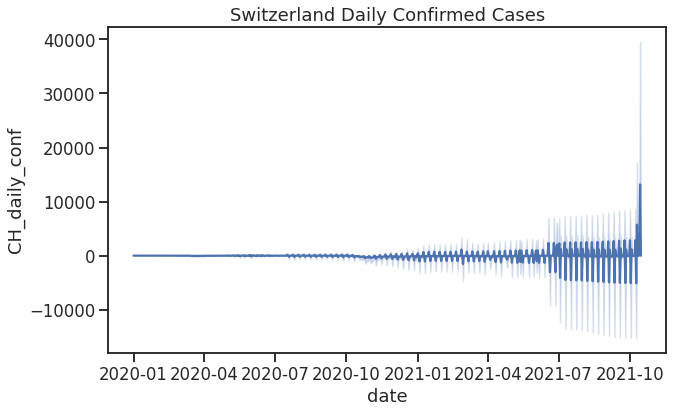

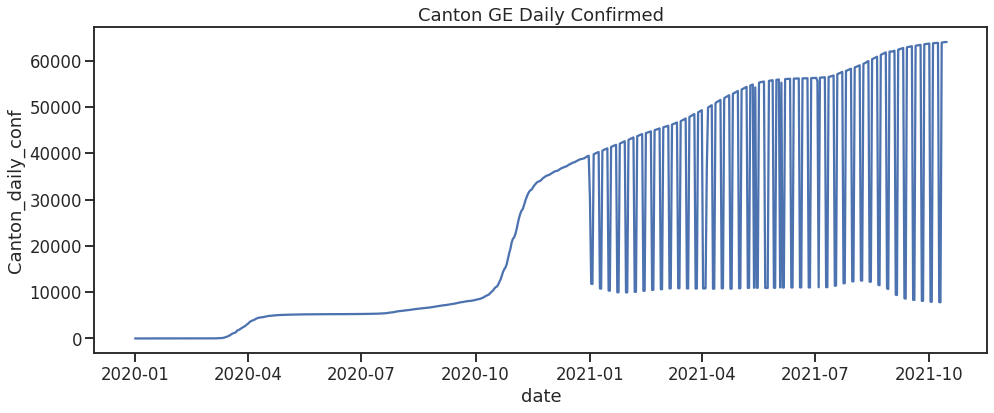

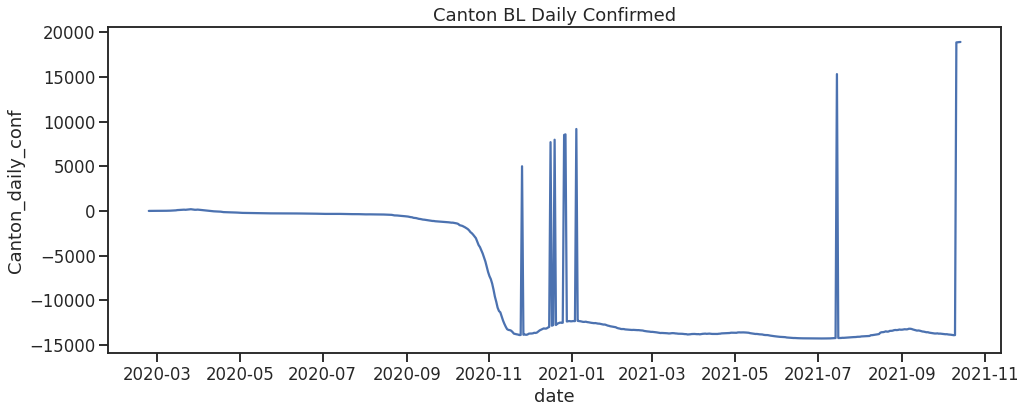

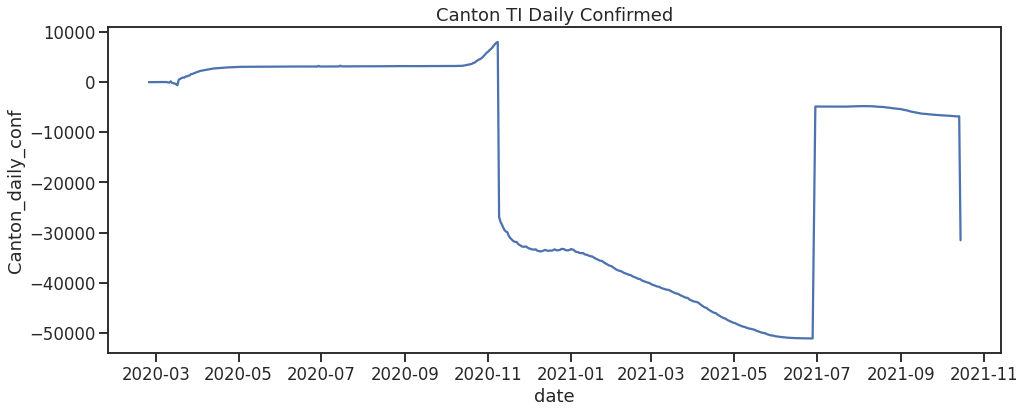

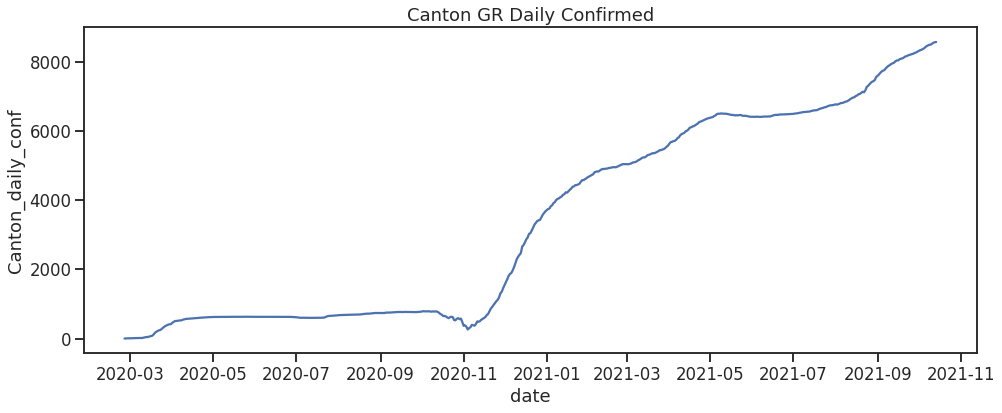

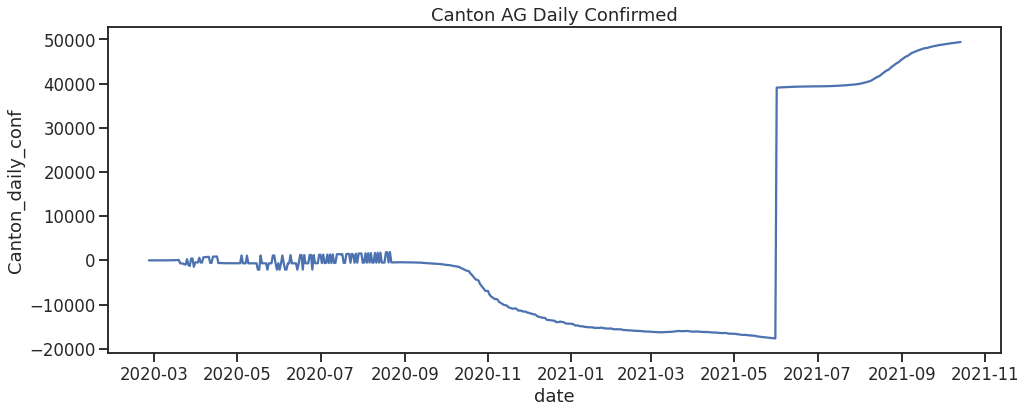

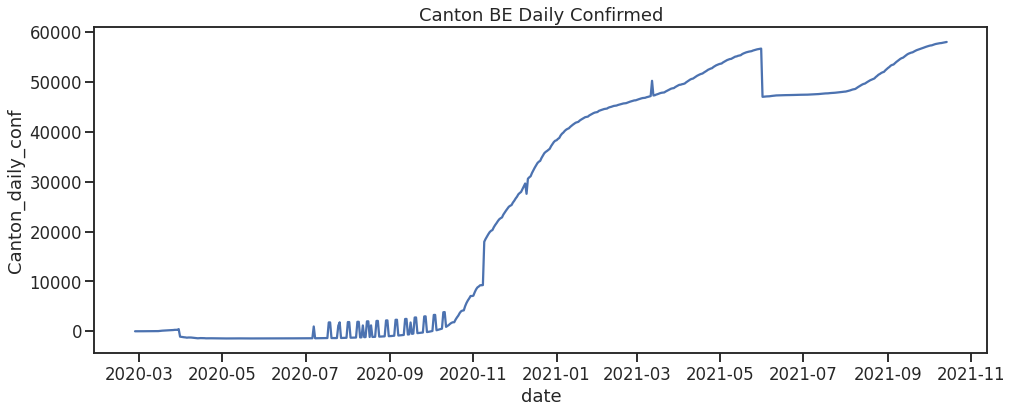

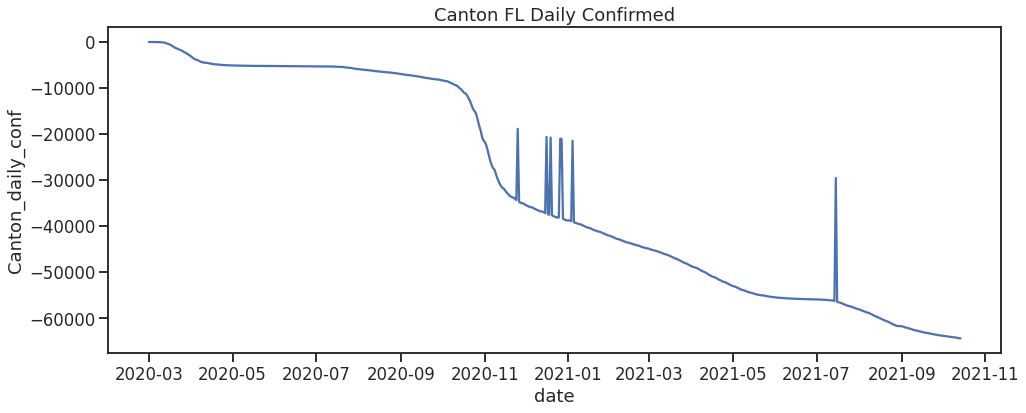

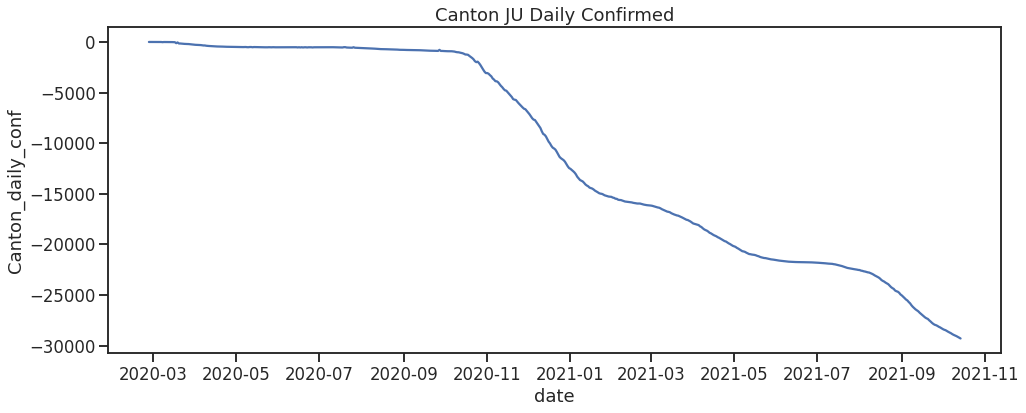

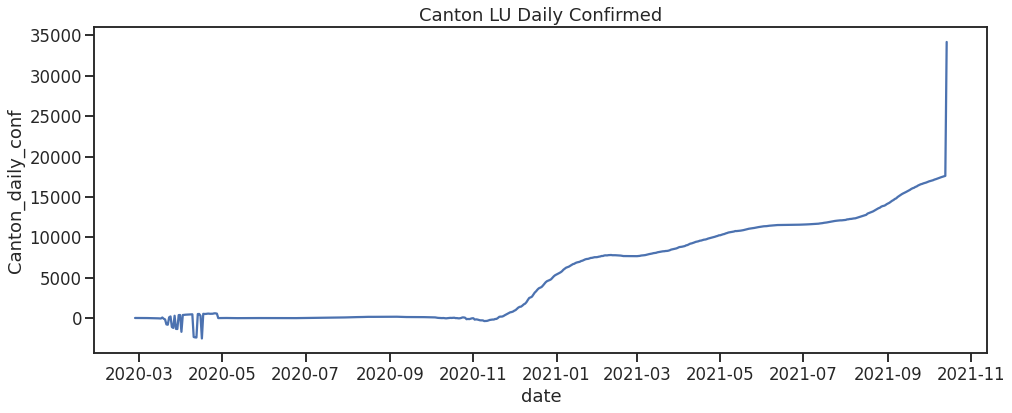

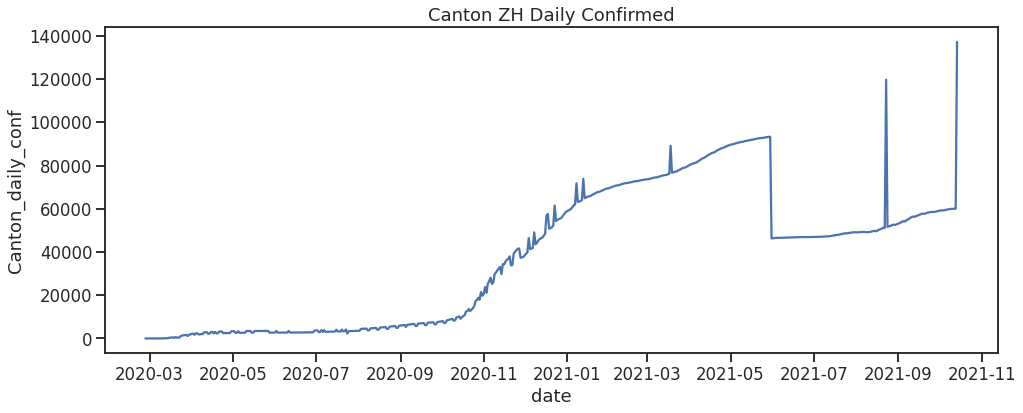

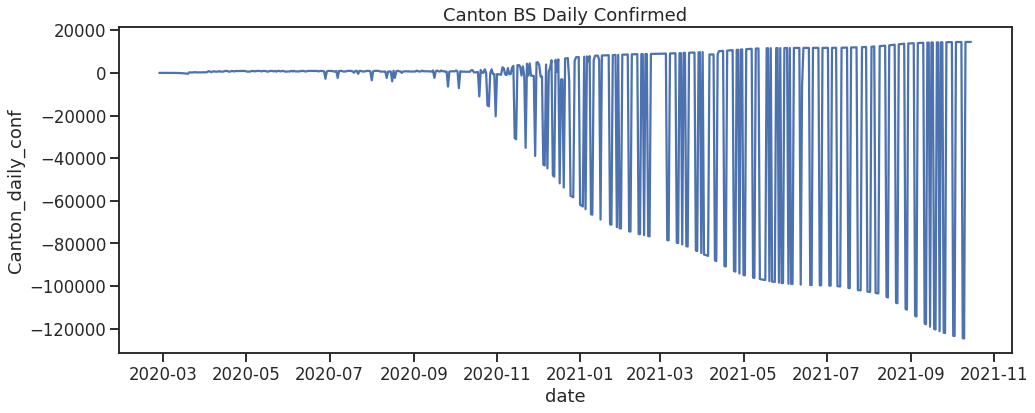

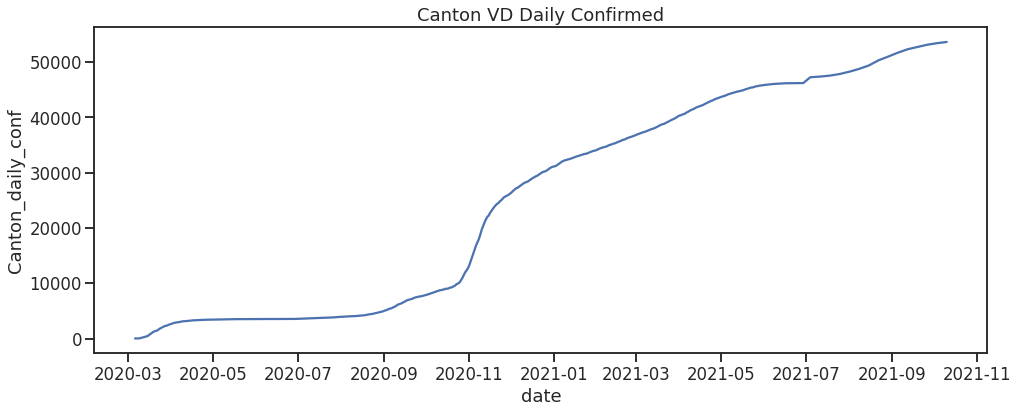

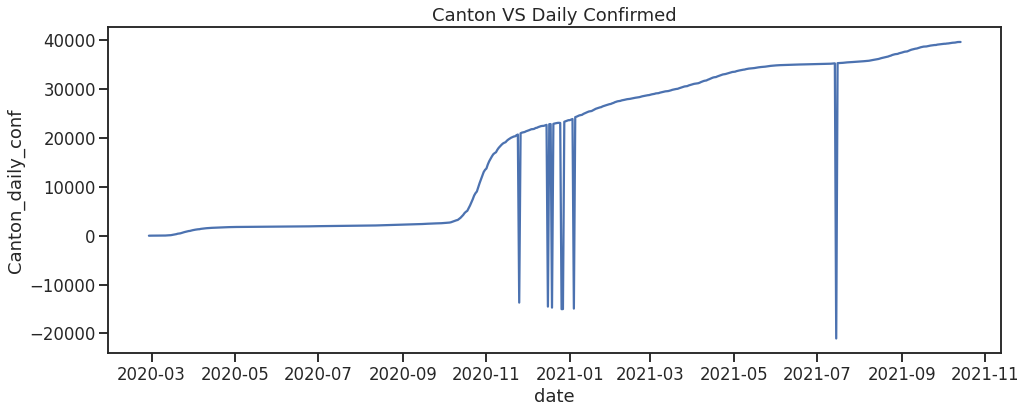

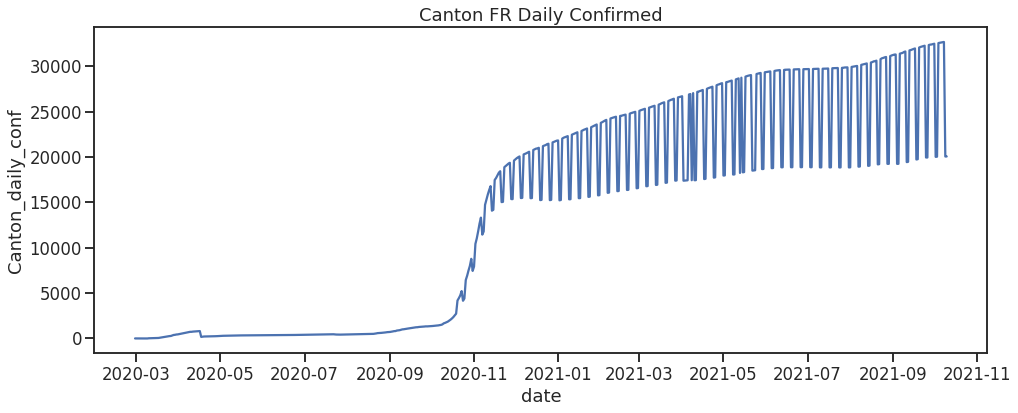

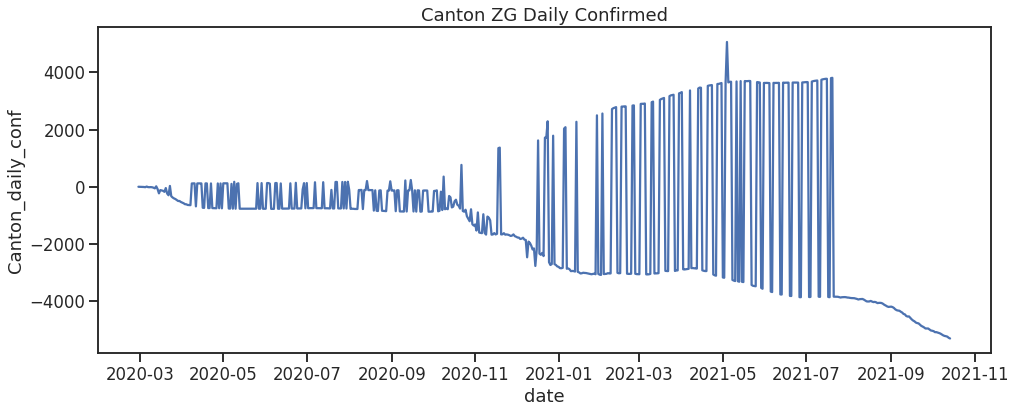

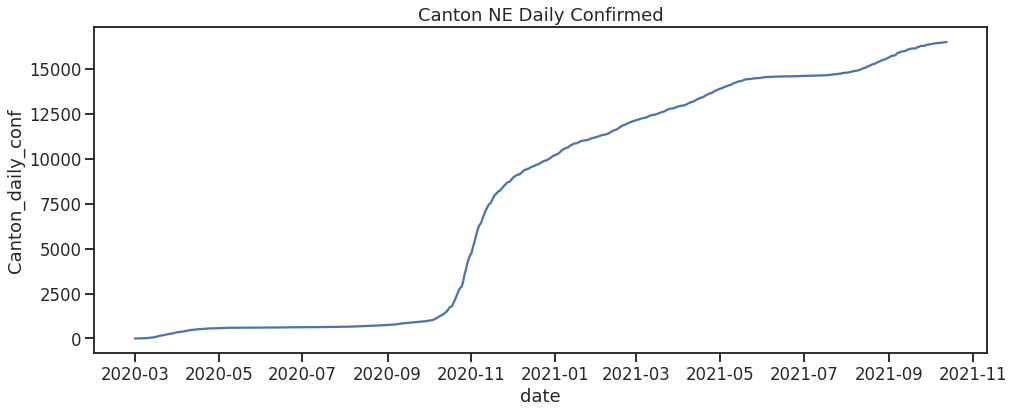

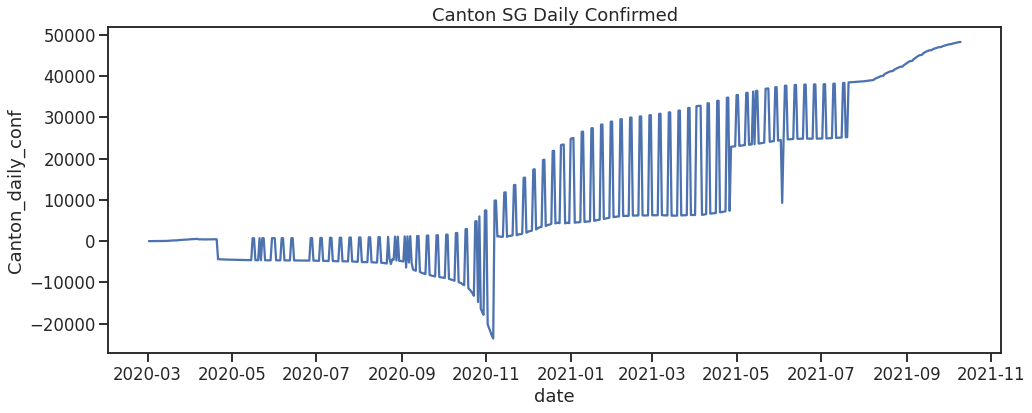

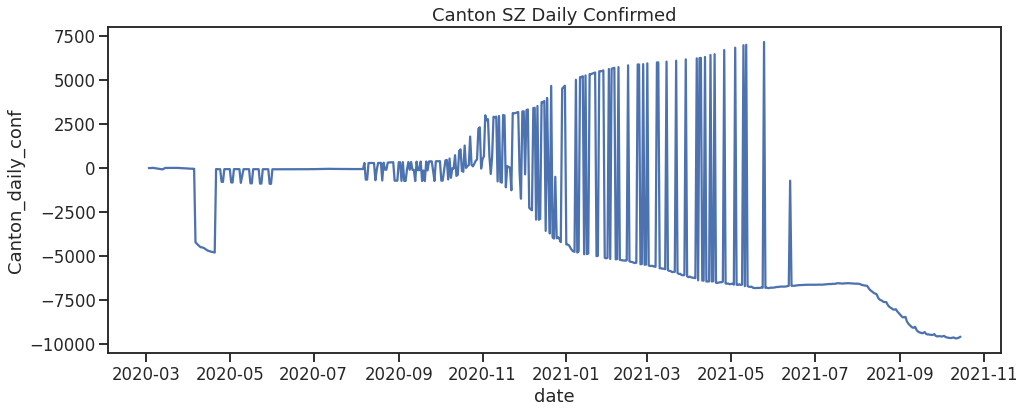

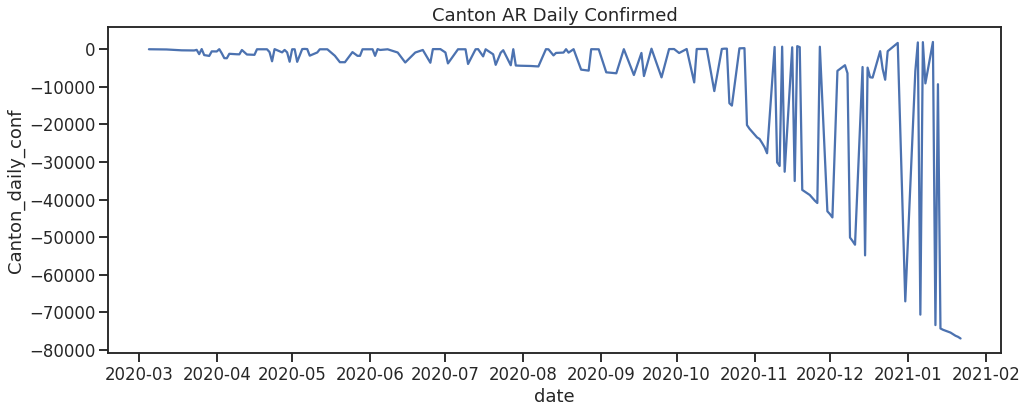

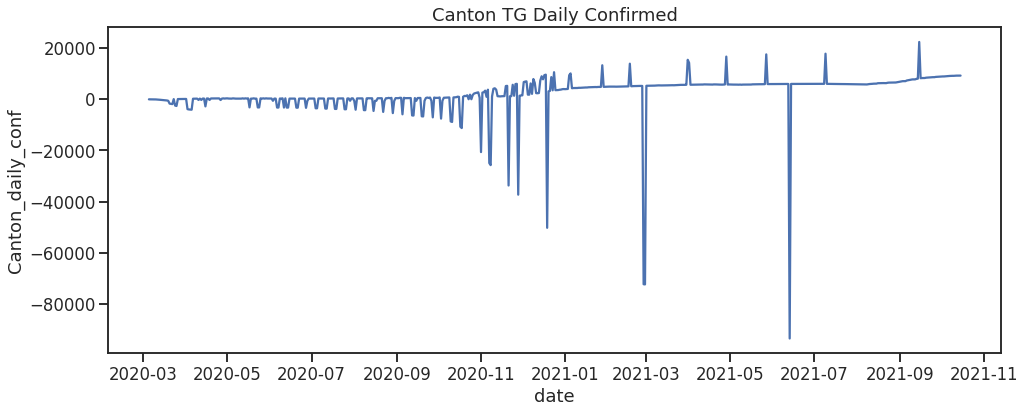

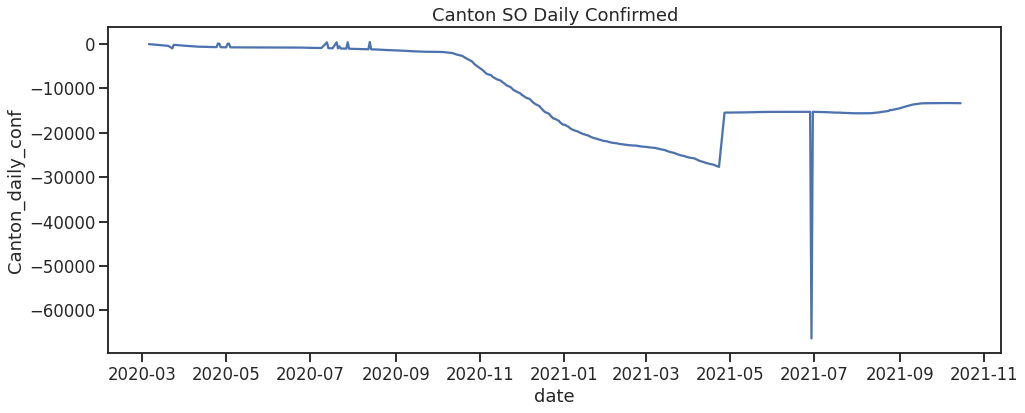

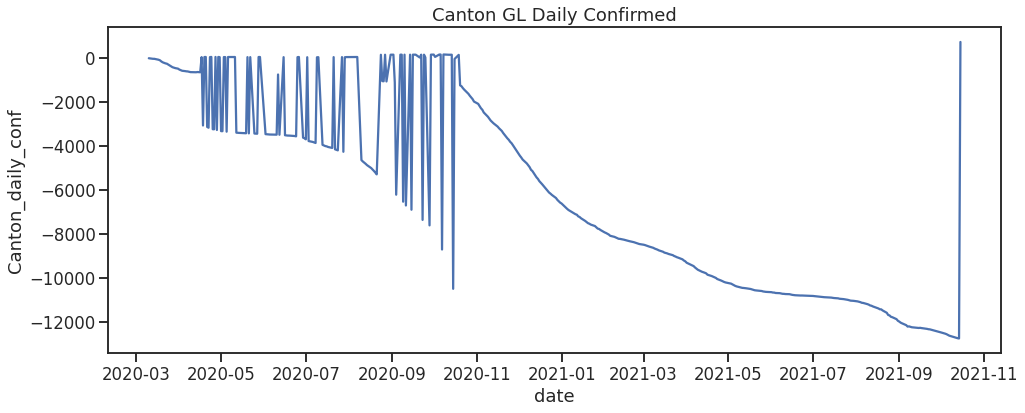

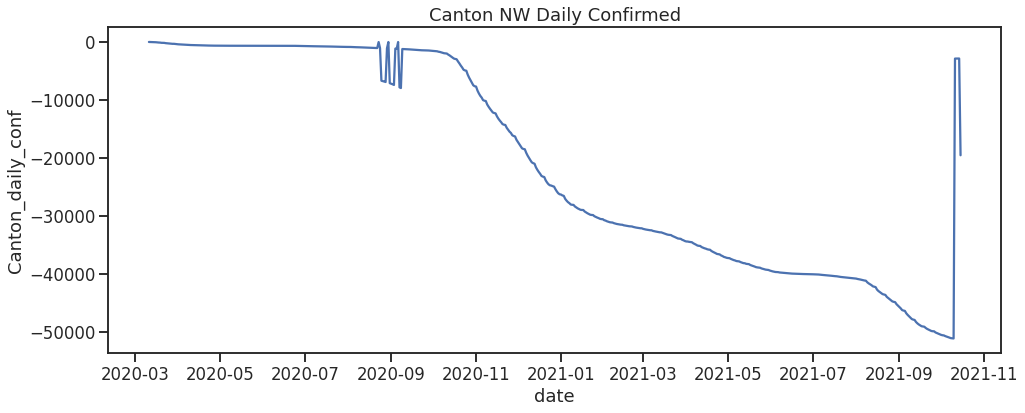

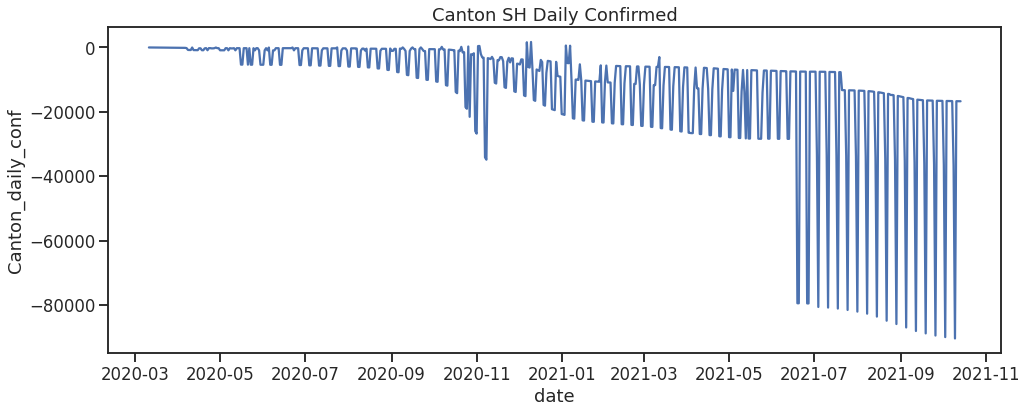

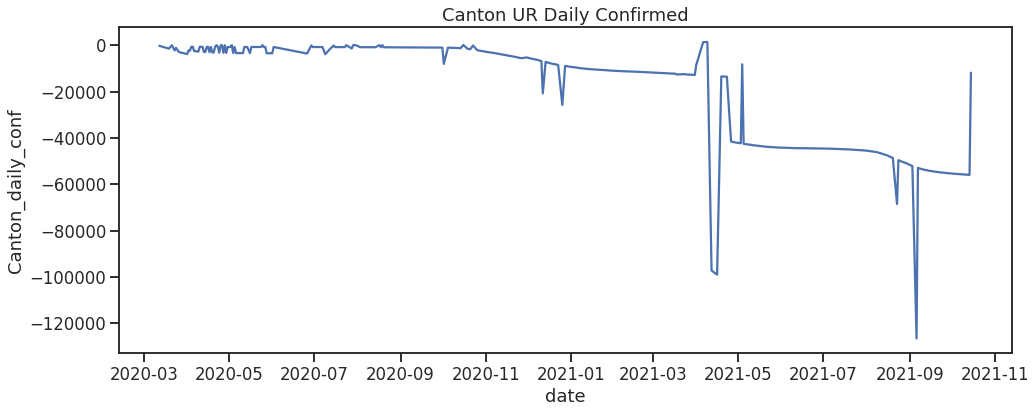

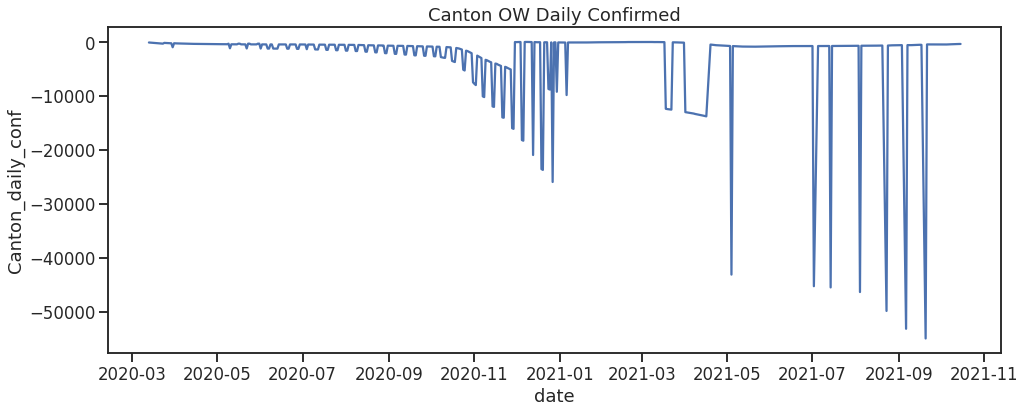

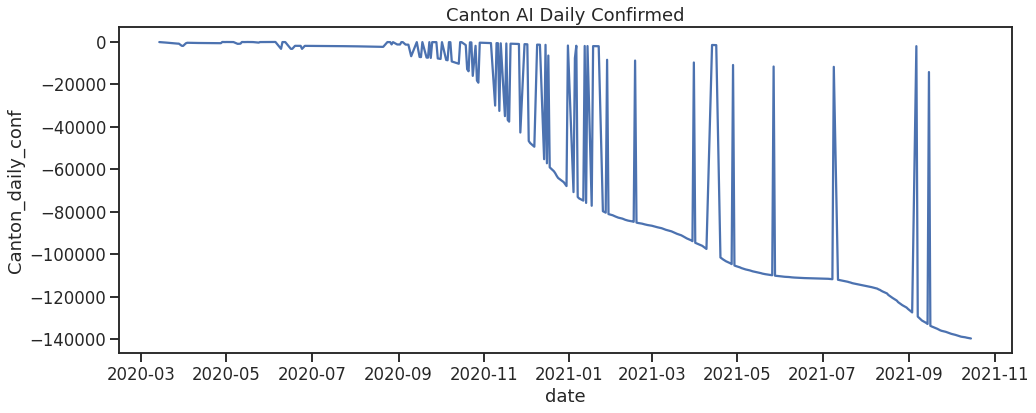

In [48]:
df_cases["Canton_daily_conf"] = df_cases["ncumul_conf"].diff(periods=-1)
df_cases['CH_daily_conf']=df_cases.loc[dates.tolist(),'CH_total'].diff(periods=-1)
plt.figure(figsize=(10,6))
plt.title("Switzerland Daily Confirmed Cases")
sns.lineplot(data=df_cases.loc[dates.tolist(),'CH_daily_conf'])

for canton in cantons:
    plt.figure(figsize=(16,6))
    plt.title("Canton {} Daily Confirmed".format(canton))
    sns.lineplot(data=df_cases.loc[(df_cases.cantons == canton),'Canton_daily_conf'])

In [38]:
dates.tolist()
df_cases.loc[dates.tolist(),'CH_total']
df_cases[dates.tolist(),'CH_total']

TypeError: '([Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-05 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-07 00:00:00'), Timestamp('2020-01-08 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-01-10 00:00:00'), Timestamp('2020-01-11 00:00:00'), Timestamp('2020-01-12 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-14 00:00:00'), Timestamp('2020-01-15 00:00:00'), Timestamp('2020-01-16 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-18 00:00:00'), Timestamp('2020-01-19 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-21 00:00:00'), Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-23 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-25 00:00:00'), Timestamp('2020-01-26 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-28 00:00:00'), Timestamp('2020-01-29 00:00:00'), Timestamp('2020-01-30 00:00:00'), Timestamp('2020-01-31 00:00:00'), Timestamp('2020-02-01 00:00:00'), Timestamp('2020-02-02 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-04 00:00:00'), Timestamp('2020-02-05 00:00:00'), Timestamp('2020-02-06 00:00:00'), Timestamp('2020-02-07 00:00:00'), Timestamp('2020-02-08 00:00:00'), Timestamp('2020-02-09 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-11 00:00:00'), Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-13 00:00:00'), Timestamp('2020-02-14 00:00:00'), Timestamp('2020-02-15 00:00:00'), Timestamp('2020-02-16 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-02-18 00:00:00'), Timestamp('2020-02-19 00:00:00'), Timestamp('2020-02-20 00:00:00'), Timestamp('2020-02-21 00:00:00'), Timestamp('2020-02-22 00:00:00'), Timestamp('2020-02-23 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-02-25 00:00:00'), Timestamp('2020-02-26 00:00:00'), Timestamp('2020-02-27 00:00:00'), Timestamp('2020-02-28 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-03 00:00:00'), Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-07 00:00:00'), Timestamp('2020-03-08 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-14 00:00:00'), Timestamp('2020-03-15 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-03-28 00:00:00'), Timestamp('2020-03-29 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-04 00:00:00'), Timestamp('2020-04-05 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-10 00:00:00'), Timestamp('2020-04-11 00:00:00'), Timestamp('2020-04-12 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-14 00:00:00'), Timestamp('2020-04-15 00:00:00'), Timestamp('2020-04-16 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-04-18 00:00:00'), Timestamp('2020-04-19 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-21 00:00:00'), Timestamp('2020-04-22 00:00:00'), Timestamp('2020-04-23 00:00:00'), Timestamp('2020-04-24 00:00:00'), Timestamp('2020-04-25 00:00:00'), Timestamp('2020-04-26 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-04-28 00:00:00'), Timestamp('2020-04-29 00:00:00'), Timestamp('2020-04-30 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-05-02 00:00:00'), Timestamp('2020-05-03 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-10 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-17 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-20 00:00:00'), Timestamp('2020-05-21 00:00:00'), Timestamp('2020-05-22 00:00:00'), Timestamp('2020-05-23 00:00:00'), Timestamp('2020-05-24 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-05-26 00:00:00'), Timestamp('2020-05-27 00:00:00'), Timestamp('2020-05-28 00:00:00'), Timestamp('2020-05-29 00:00:00'), Timestamp('2020-05-30 00:00:00'), Timestamp('2020-05-31 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-06 00:00:00'), Timestamp('2020-06-07 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-09 00:00:00'), Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-14 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-06-17 00:00:00'), Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'), Timestamp('2020-06-20 00:00:00'), Timestamp('2020-06-21 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-23 00:00:00'), Timestamp('2020-06-24 00:00:00'), Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00'), Timestamp('2020-06-27 00:00:00'), Timestamp('2020-06-28 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-01 00:00:00'), Timestamp('2020-07-02 00:00:00'), Timestamp('2020-07-03 00:00:00'), Timestamp('2020-07-04 00:00:00'), Timestamp('2020-07-05 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('2020-07-07 00:00:00'), Timestamp('2020-07-08 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-11 00:00:00'), Timestamp('2020-07-12 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-07-17 00:00:00'), Timestamp('2020-07-18 00:00:00'), Timestamp('2020-07-19 00:00:00'), Timestamp('2020-07-20 00:00:00'), Timestamp('2020-07-21 00:00:00'), Timestamp('2020-07-22 00:00:00'), Timestamp('2020-07-23 00:00:00'), Timestamp('2020-07-24 00:00:00'), Timestamp('2020-07-25 00:00:00'), Timestamp('2020-07-26 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-07-28 00:00:00'), Timestamp('2020-07-29 00:00:00'), Timestamp('2020-07-30 00:00:00'), Timestamp('2020-07-31 00:00:00'), Timestamp('2020-08-01 00:00:00'), Timestamp('2020-08-02 00:00:00'), Timestamp('2020-08-03 00:00:00'), Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-05 00:00:00'), Timestamp('2020-08-06 00:00:00'), Timestamp('2020-08-07 00:00:00'), Timestamp('2020-08-08 00:00:00'), Timestamp('2020-08-09 00:00:00'), Timestamp('2020-08-10 00:00:00'), Timestamp('2020-08-11 00:00:00'), Timestamp('2020-08-12 00:00:00'), Timestamp('2020-08-13 00:00:00'), Timestamp('2020-08-14 00:00:00'), Timestamp('2020-08-15 00:00:00'), Timestamp('2020-08-16 00:00:00'), Timestamp('2020-08-17 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-22 00:00:00'), Timestamp('2020-08-23 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-29 00:00:00'), Timestamp('2020-08-30 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-01 00:00:00'), Timestamp('2020-09-02 00:00:00'), Timestamp('2020-09-03 00:00:00'), Timestamp('2020-09-04 00:00:00'), Timestamp('2020-09-05 00:00:00'), Timestamp('2020-09-06 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-09-09 00:00:00'), Timestamp('2020-09-10 00:00:00'), Timestamp('2020-09-11 00:00:00'), Timestamp('2020-09-12 00:00:00'), Timestamp('2020-09-13 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-09-17 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-09-19 00:00:00'), Timestamp('2020-09-20 00:00:00'), Timestamp('2020-09-21 00:00:00'), Timestamp('2020-09-22 00:00:00'), Timestamp('2020-09-23 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-09-25 00:00:00'), Timestamp('2020-09-26 00:00:00'), Timestamp('2020-09-27 00:00:00'), Timestamp('2020-09-28 00:00:00'), Timestamp('2020-09-29 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-01 00:00:00'), Timestamp('2020-10-02 00:00:00'), Timestamp('2020-10-03 00:00:00'), Timestamp('2020-10-04 00:00:00'), Timestamp('2020-10-05 00:00:00'), Timestamp('2020-10-06 00:00:00'), Timestamp('2020-10-07 00:00:00'), Timestamp('2020-10-08 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-10-10 00:00:00'), Timestamp('2020-10-11 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-13 00:00:00'), Timestamp('2020-10-14 00:00:00'), Timestamp('2020-10-15 00:00:00'), Timestamp('2020-10-16 00:00:00'), Timestamp('2020-10-17 00:00:00'), Timestamp('2020-10-18 00:00:00'), Timestamp('2020-10-19 00:00:00'), Timestamp('2020-10-20 00:00:00'), Timestamp('2020-10-21 00:00:00'), Timestamp('2020-10-22 00:00:00'), Timestamp('2020-10-23 00:00:00'), Timestamp('2020-10-24 00:00:00'), Timestamp('2020-10-25 00:00:00'), Timestamp('2020-10-26 00:00:00'), Timestamp('2020-10-27 00:00:00'), Timestamp('2020-10-28 00:00:00'), Timestamp('2020-10-29 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-01 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-03 00:00:00'), Timestamp('2020-11-04 00:00:00'), Timestamp('2020-11-05 00:00:00'), Timestamp('2020-11-06 00:00:00'), Timestamp('2020-11-07 00:00:00'), Timestamp('2020-11-08 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-10 00:00:00'), Timestamp('2020-11-11 00:00:00'), Timestamp('2020-11-12 00:00:00'), Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-14 00:00:00'), Timestamp('2020-11-15 00:00:00'), Timestamp('2020-11-16 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-18 00:00:00'), Timestamp('2020-11-19 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-21 00:00:00'), Timestamp('2020-11-22 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-11-28 00:00:00'), Timestamp('2020-11-29 00:00:00'), Timestamp('2020-11-30 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-03 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-05 00:00:00'), Timestamp('2020-12-06 00:00:00'), Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-10 00:00:00'), Timestamp('2020-12-11 00:00:00'), Timestamp('2020-12-12 00:00:00'), Timestamp('2020-12-13 00:00:00'), Timestamp('2020-12-14 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-19 00:00:00'), Timestamp('2020-12-20 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2020-12-26 00:00:00'), Timestamp('2020-12-27 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-03 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-10 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-16 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-18 00:00:00'), Timestamp('2021-01-19 00:00:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-23 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-01-29 00:00:00'), Timestamp('2021-01-30 00:00:00'), Timestamp('2021-01-31 00:00:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-02-02 00:00:00'), Timestamp('2021-02-03 00:00:00'), Timestamp('2021-02-04 00:00:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-06 00:00:00'), Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-08 00:00:00'), Timestamp('2021-02-09 00:00:00'), Timestamp('2021-02-10 00:00:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-13 00:00:00'), Timestamp('2021-02-14 00:00:00'), Timestamp('2021-02-15 00:00:00'), Timestamp('2021-02-16 00:00:00'), Timestamp('2021-02-17 00:00:00'), Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-20 00:00:00'), Timestamp('2021-02-21 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00'), Timestamp('2021-02-24 00:00:00'), Timestamp('2021-02-25 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2021-02-27 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-01 00:00:00'), Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-03 00:00:00'), Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-06 00:00:00'), Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-10 00:00:00'), Timestamp('2021-03-11 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-13 00:00:00'), Timestamp('2021-03-14 00:00:00'), Timestamp('2021-03-15 00:00:00'), Timestamp('2021-03-16 00:00:00'), Timestamp('2021-03-17 00:00:00'), Timestamp('2021-03-18 00:00:00'), Timestamp('2021-03-19 00:00:00'), Timestamp('2021-03-20 00:00:00'), Timestamp('2021-03-21 00:00:00'), Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-23 00:00:00'), Timestamp('2021-03-24 00:00:00'), Timestamp('2021-03-25 00:00:00'), Timestamp('2021-03-26 00:00:00'), Timestamp('2021-03-27 00:00:00'), Timestamp('2021-03-28 00:00:00'), Timestamp('2021-03-29 00:00:00'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-02 00:00:00'), Timestamp('2021-04-03 00:00:00'), Timestamp('2021-04-04 00:00:00'), Timestamp('2021-04-05 00:00:00'), Timestamp('2021-04-06 00:00:00'), Timestamp('2021-04-07 00:00:00'), Timestamp('2021-04-08 00:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-10 00:00:00'), Timestamp('2021-04-11 00:00:00'), Timestamp('2021-04-12 00:00:00'), Timestamp('2021-04-13 00:00:00'), Timestamp('2021-04-14 00:00:00'), Timestamp('2021-04-15 00:00:00'), Timestamp('2021-04-16 00:00:00'), Timestamp('2021-04-17 00:00:00'), Timestamp('2021-04-18 00:00:00'), Timestamp('2021-04-19 00:00:00'), Timestamp('2021-04-20 00:00:00'), Timestamp('2021-04-21 00:00:00'), Timestamp('2021-04-22 00:00:00'), Timestamp('2021-04-23 00:00:00'), Timestamp('2021-04-24 00:00:00'), Timestamp('2021-04-25 00:00:00'), Timestamp('2021-04-26 00:00:00'), Timestamp('2021-04-27 00:00:00'), Timestamp('2021-04-28 00:00:00'), Timestamp('2021-04-29 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-01 00:00:00'), Timestamp('2021-05-02 00:00:00'), Timestamp('2021-05-03 00:00:00'), Timestamp('2021-05-04 00:00:00'), Timestamp('2021-05-05 00:00:00'), Timestamp('2021-05-06 00:00:00'), Timestamp('2021-05-07 00:00:00'), Timestamp('2021-05-08 00:00:00'), Timestamp('2021-05-09 00:00:00'), Timestamp('2021-05-10 00:00:00'), Timestamp('2021-05-11 00:00:00'), Timestamp('2021-05-12 00:00:00'), Timestamp('2021-05-13 00:00:00'), Timestamp('2021-05-14 00:00:00'), Timestamp('2021-05-15 00:00:00'), Timestamp('2021-05-16 00:00:00'), Timestamp('2021-05-17 00:00:00'), Timestamp('2021-05-18 00:00:00'), Timestamp('2021-05-19 00:00:00'), Timestamp('2021-05-20 00:00:00'), Timestamp('2021-05-21 00:00:00'), Timestamp('2021-05-22 00:00:00'), Timestamp('2021-05-23 00:00:00'), Timestamp('2021-05-24 00:00:00'), Timestamp('2021-05-25 00:00:00'), Timestamp('2021-05-26 00:00:00'), Timestamp('2021-05-27 00:00:00'), Timestamp('2021-05-28 00:00:00'), Timestamp('2021-05-29 00:00:00'), Timestamp('2021-05-30 00:00:00'), Timestamp('2021-05-31 00:00:00'), Timestamp('2021-06-01 00:00:00'), Timestamp('2021-06-02 00:00:00'), Timestamp('2021-06-03 00:00:00'), Timestamp('2021-06-04 00:00:00'), Timestamp('2021-06-05 00:00:00'), Timestamp('2021-06-06 00:00:00'), Timestamp('2021-06-07 00:00:00'), Timestamp('2021-06-08 00:00:00'), Timestamp('2021-06-09 00:00:00'), Timestamp('2021-06-10 00:00:00'), Timestamp('2021-06-11 00:00:00'), Timestamp('2021-06-12 00:00:00'), Timestamp('2021-06-13 00:00:00'), Timestamp('2021-06-14 00:00:00'), Timestamp('2021-06-15 00:00:00'), Timestamp('2021-06-16 00:00:00'), Timestamp('2021-06-17 00:00:00'), Timestamp('2021-06-18 00:00:00'), Timestamp('2021-06-19 00:00:00'), Timestamp('2021-06-20 00:00:00'), Timestamp('2021-06-21 00:00:00'), Timestamp('2021-06-22 00:00:00'), Timestamp('2021-06-23 00:00:00'), Timestamp('2021-06-24 00:00:00'), Timestamp('2021-06-25 00:00:00'), Timestamp('2021-06-26 00:00:00'), Timestamp('2021-06-27 00:00:00'), Timestamp('2021-06-28 00:00:00'), Timestamp('2021-06-29 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-01 00:00:00'), Timestamp('2021-07-02 00:00:00'), Timestamp('2021-07-03 00:00:00'), Timestamp('2021-07-04 00:00:00'), Timestamp('2021-07-05 00:00:00'), Timestamp('2021-07-06 00:00:00'), Timestamp('2021-07-07 00:00:00'), Timestamp('2021-07-08 00:00:00'), Timestamp('2021-07-09 00:00:00'), Timestamp('2021-07-10 00:00:00'), Timestamp('2021-07-11 00:00:00'), Timestamp('2021-07-12 00:00:00'), Timestamp('2021-07-13 00:00:00'), Timestamp('2021-07-14 00:00:00'), Timestamp('2021-07-15 00:00:00'), Timestamp('2021-07-16 00:00:00'), Timestamp('2021-07-17 00:00:00'), Timestamp('2021-07-18 00:00:00'), Timestamp('2021-07-19 00:00:00'), Timestamp('2021-07-20 00:00:00'), Timestamp('2021-07-21 00:00:00'), Timestamp('2021-07-22 00:00:00'), Timestamp('2021-07-23 00:00:00'), Timestamp('2021-07-24 00:00:00'), Timestamp('2021-07-25 00:00:00'), Timestamp('2021-07-26 00:00:00'), Timestamp('2021-07-27 00:00:00'), Timestamp('2021-07-28 00:00:00'), Timestamp('2021-07-29 00:00:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-07-31 00:00:00'), Timestamp('2021-08-01 00:00:00'), Timestamp('2021-08-02 00:00:00'), Timestamp('2021-08-03 00:00:00'), Timestamp('2021-08-04 00:00:00'), Timestamp('2021-08-05 00:00:00'), Timestamp('2021-08-06 00:00:00'), Timestamp('2021-08-07 00:00:00'), Timestamp('2021-08-08 00:00:00'), Timestamp('2021-08-09 00:00:00'), Timestamp('2021-08-10 00:00:00'), Timestamp('2021-08-11 00:00:00'), Timestamp('2021-08-12 00:00:00'), Timestamp('2021-08-13 00:00:00'), Timestamp('2021-08-14 00:00:00'), Timestamp('2021-08-15 00:00:00'), Timestamp('2021-08-16 00:00:00'), Timestamp('2021-08-17 00:00:00'), Timestamp('2021-08-18 00:00:00'), Timestamp('2021-08-19 00:00:00'), Timestamp('2021-08-20 00:00:00'), Timestamp('2021-08-21 00:00:00'), Timestamp('2021-08-22 00:00:00'), Timestamp('2021-08-23 00:00:00'), Timestamp('2021-08-24 00:00:00'), Timestamp('2021-08-25 00:00:00'), Timestamp('2021-08-26 00:00:00'), Timestamp('2021-08-27 00:00:00'), Timestamp('2021-08-28 00:00:00'), Timestamp('2021-08-29 00:00:00'), Timestamp('2021-08-30 00:00:00'), Timestamp('2021-08-31 00:00:00'), Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-02 00:00:00'), Timestamp('2021-09-03 00:00:00'), Timestamp('2021-09-04 00:00:00'), Timestamp('2021-09-05 00:00:00'), Timestamp('2021-09-06 00:00:00'), Timestamp('2021-09-07 00:00:00'), Timestamp('2021-09-08 00:00:00'), Timestamp('2021-09-09 00:00:00'), Timestamp('2021-09-10 00:00:00'), Timestamp('2021-09-11 00:00:00'), Timestamp('2021-09-12 00:00:00'), Timestamp('2021-09-13 00:00:00'), Timestamp('2021-09-14 00:00:00'), Timestamp('2021-09-15 00:00:00'), Timestamp('2021-09-16 00:00:00'), Timestamp('2021-09-17 00:00:00'), Timestamp('2021-09-18 00:00:00'), Timestamp('2021-09-19 00:00:00'), Timestamp('2021-09-20 00:00:00'), Timestamp('2021-09-21 00:00:00'), Timestamp('2021-09-22 00:00:00'), Timestamp('2021-09-23 00:00:00'), Timestamp('2021-09-24 00:00:00'), Timestamp('2021-09-25 00:00:00'), Timestamp('2021-09-26 00:00:00'), Timestamp('2021-09-27 00:00:00'), Timestamp('2021-09-28 00:00:00'), Timestamp('2021-09-29 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-02 00:00:00'), Timestamp('2021-10-03 00:00:00'), Timestamp('2021-10-04 00:00:00'), Timestamp('2021-10-05 00:00:00')], 'CH_total')' is an invalid key

In [31]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 
daily_increase()    

# Visualization

In [94]:
df_cases.head()
df_cases.dropna(how='all',inplace=True)
#df_cases.fillna(method='ffill',inplace=True)
df_cases.head(100)
df_cases.isnull().sum()

cantons        0
ncumul_conf    0
CH_total       0
dtype: int64

# Cantons Confirmed Cases Vistualization 

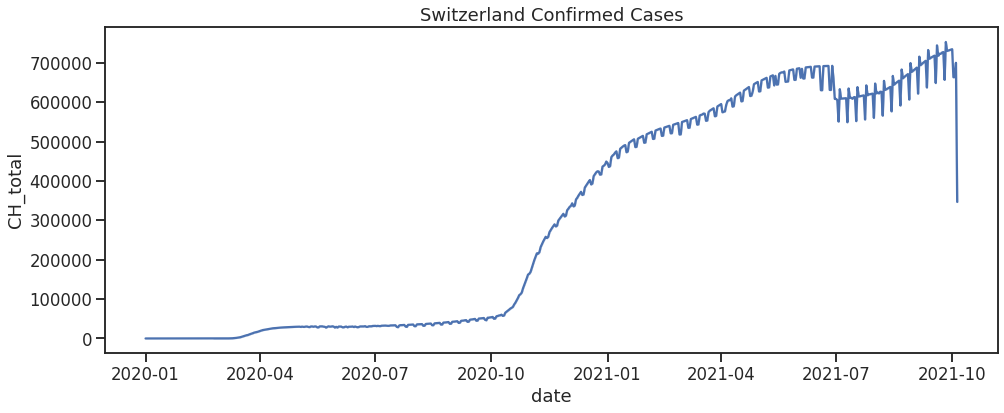

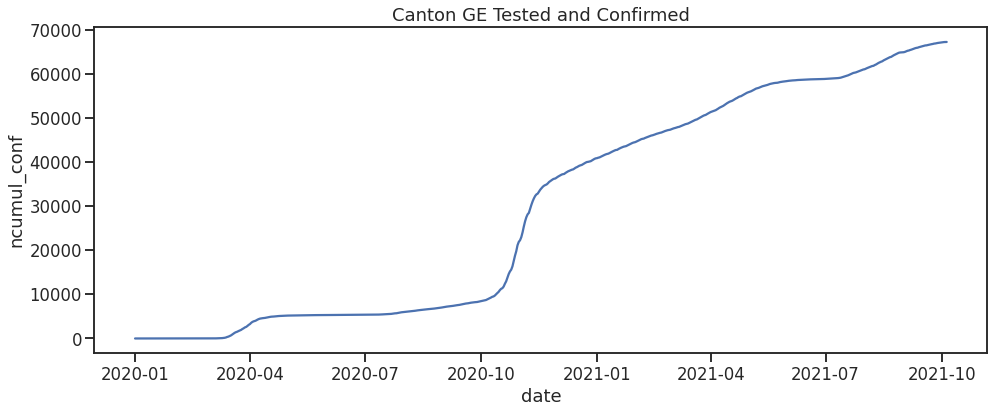

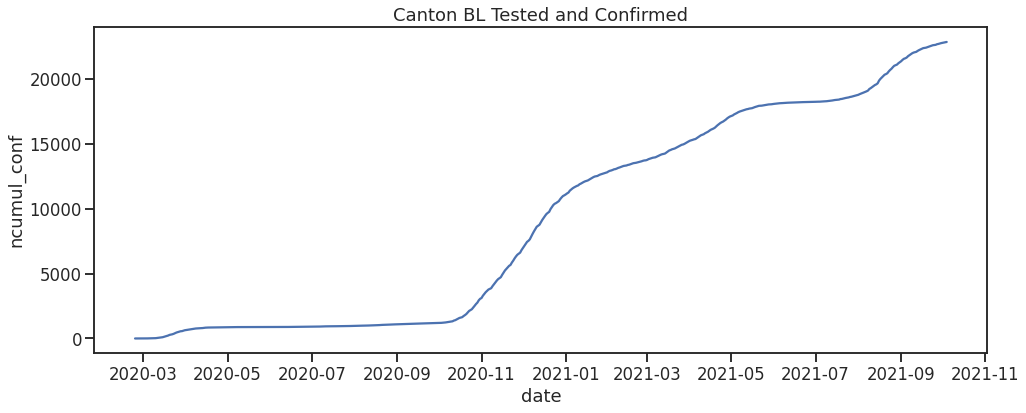

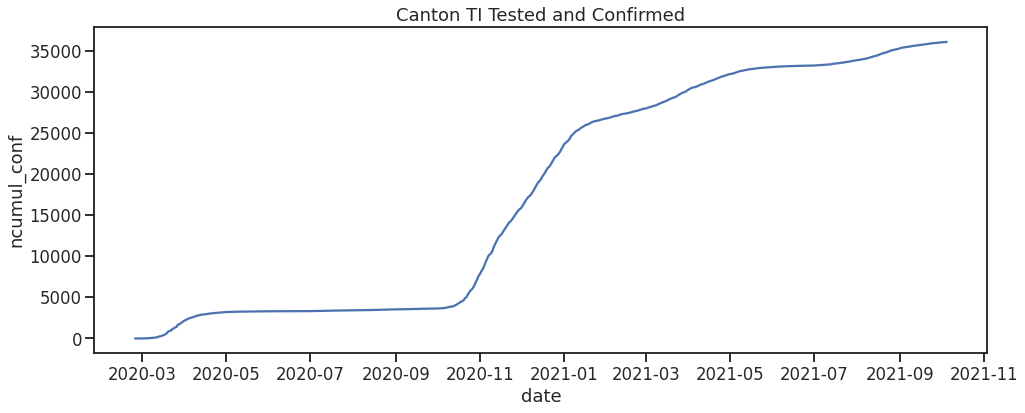

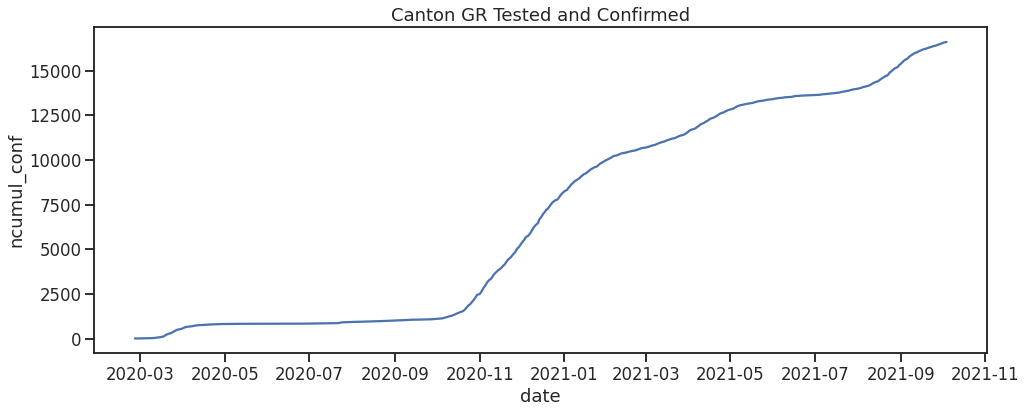

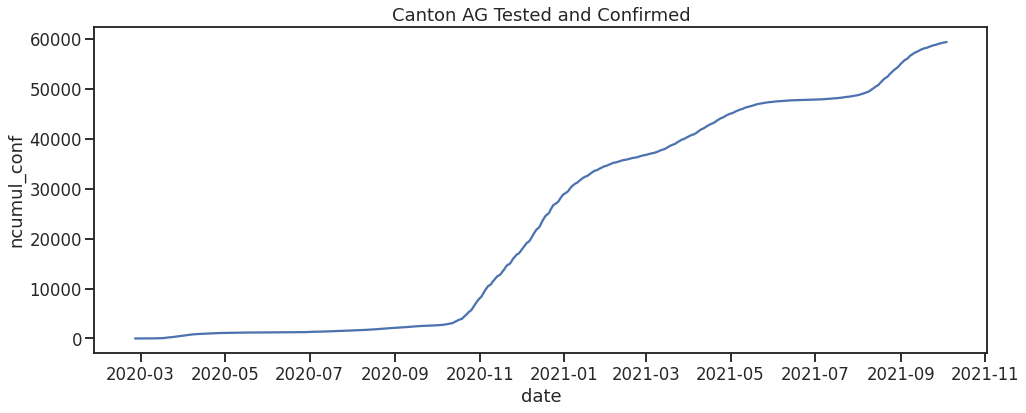

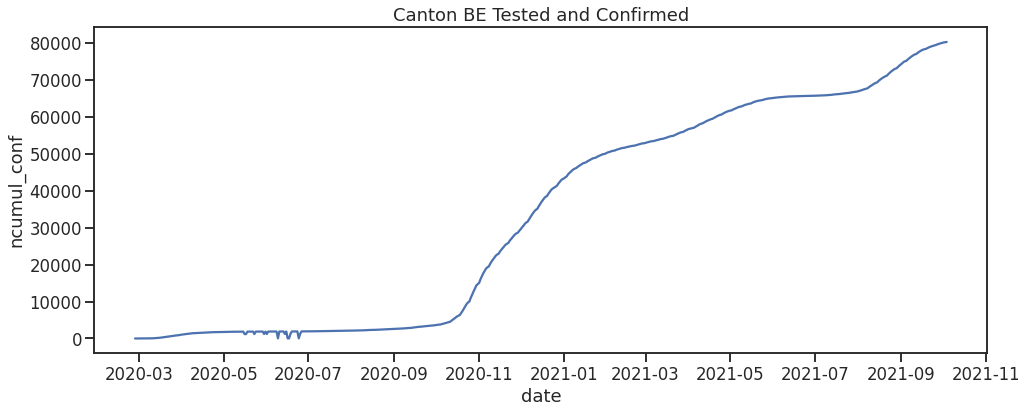

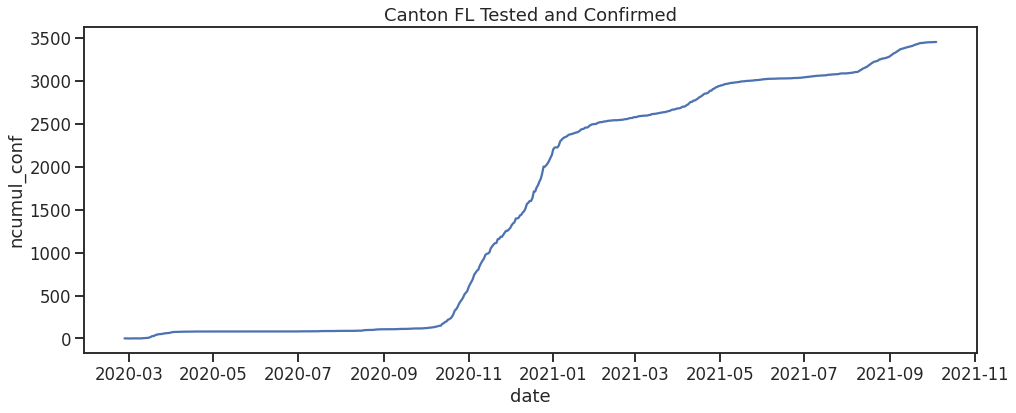

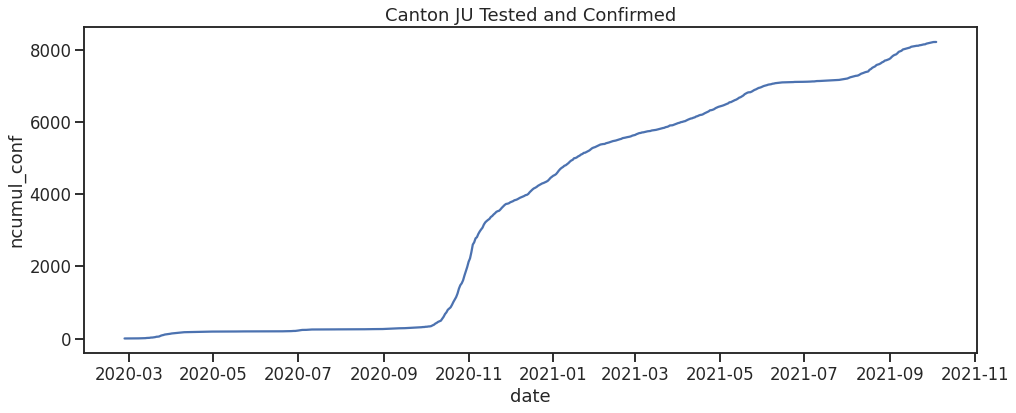

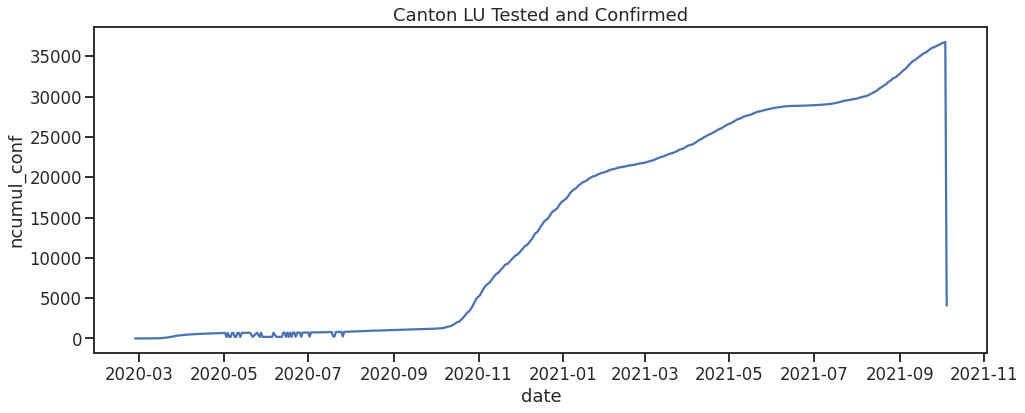

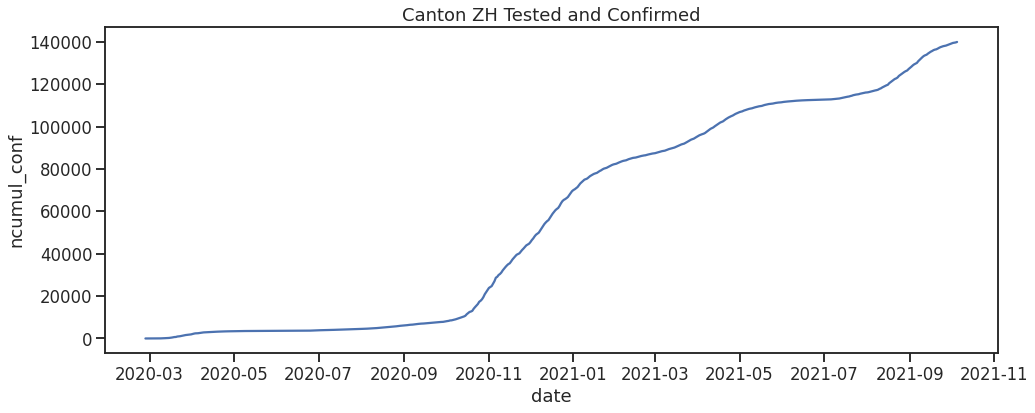

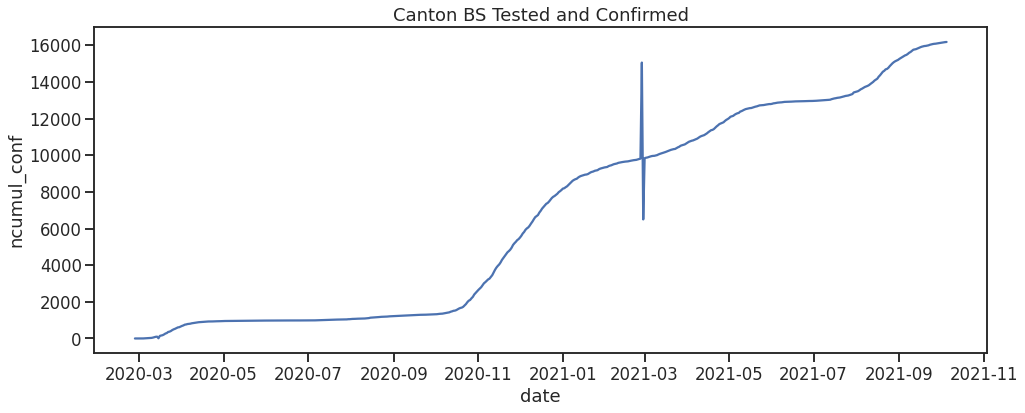

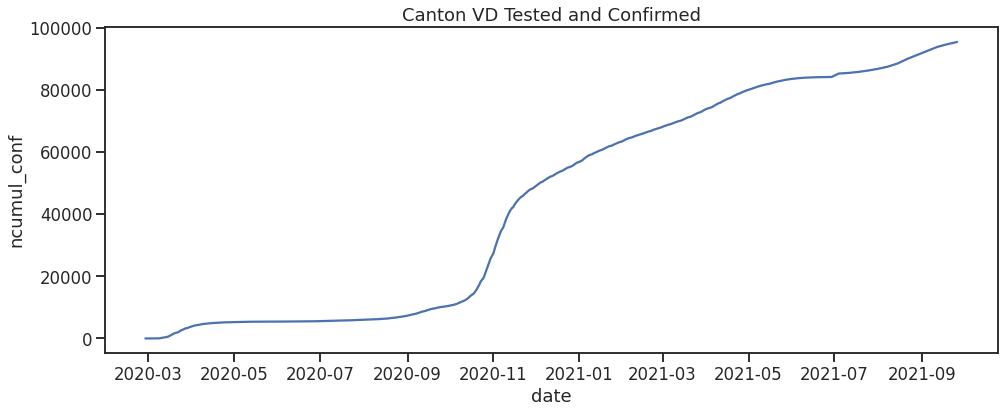

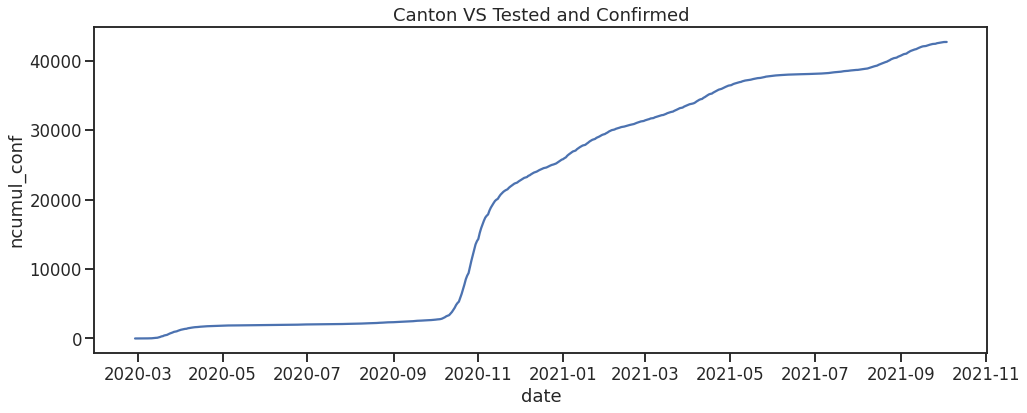

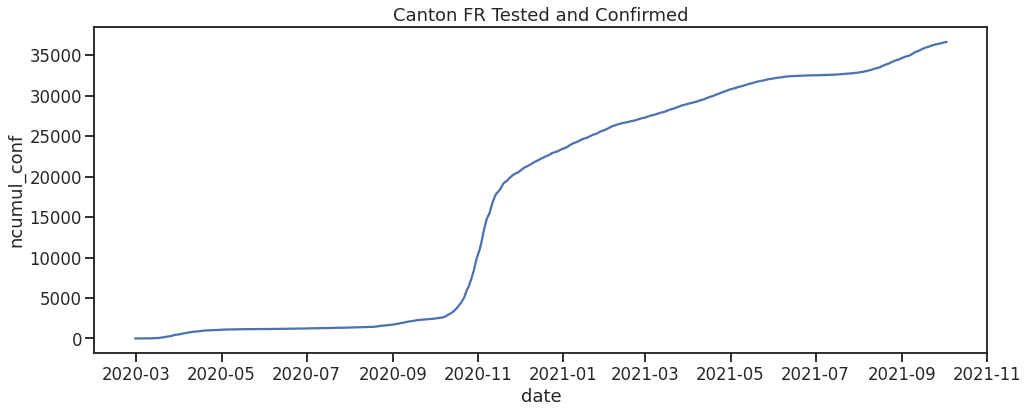

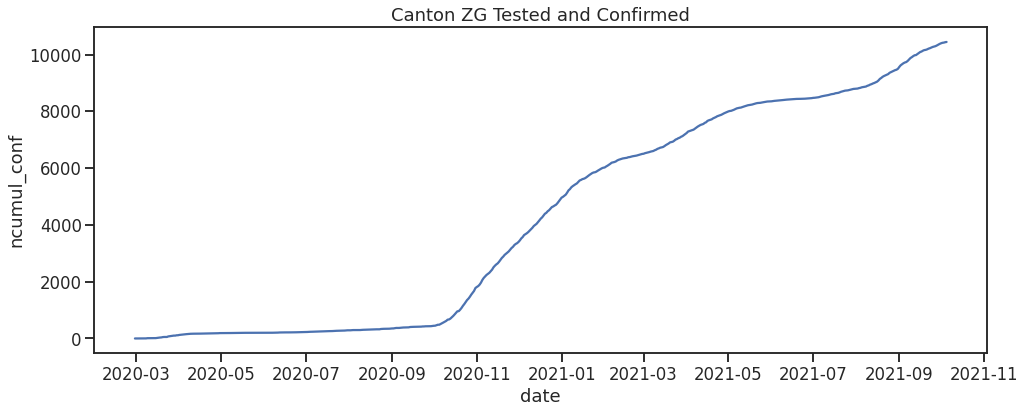

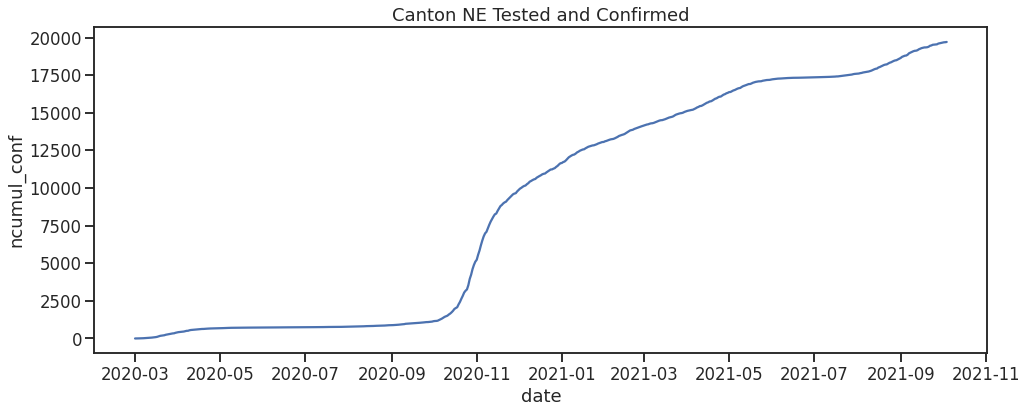

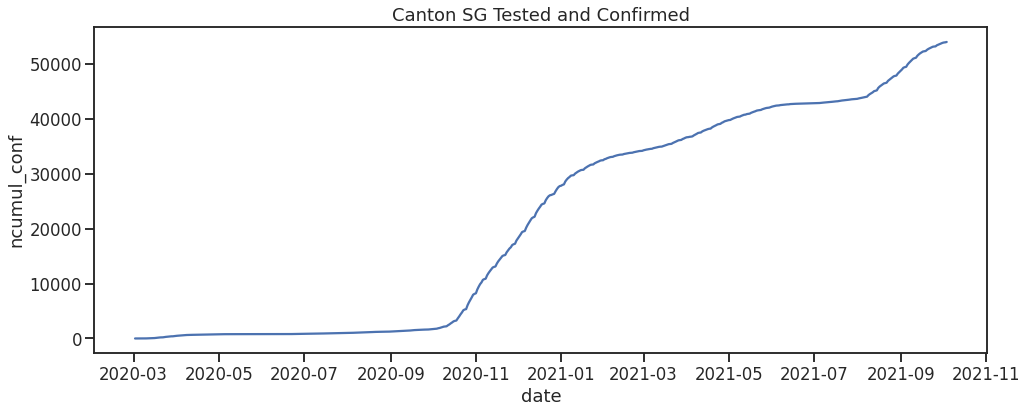

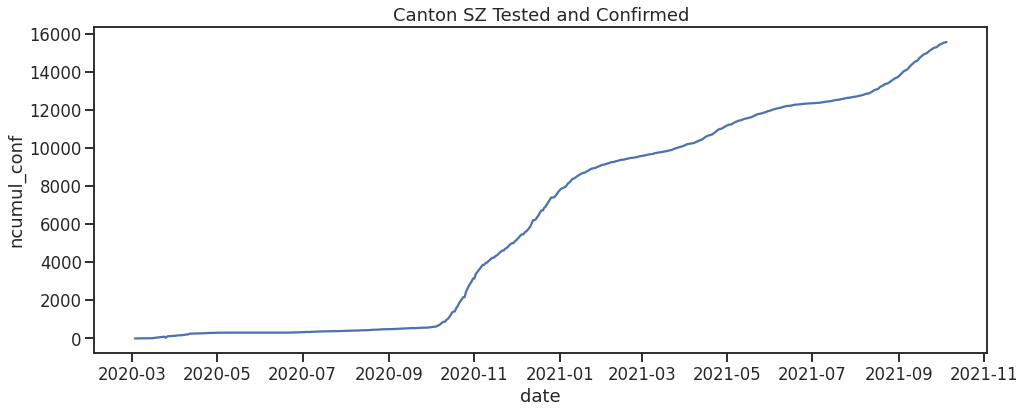

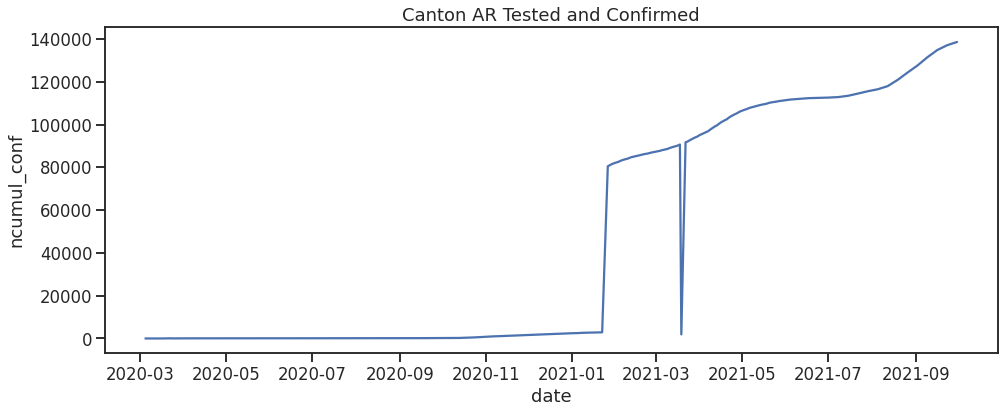

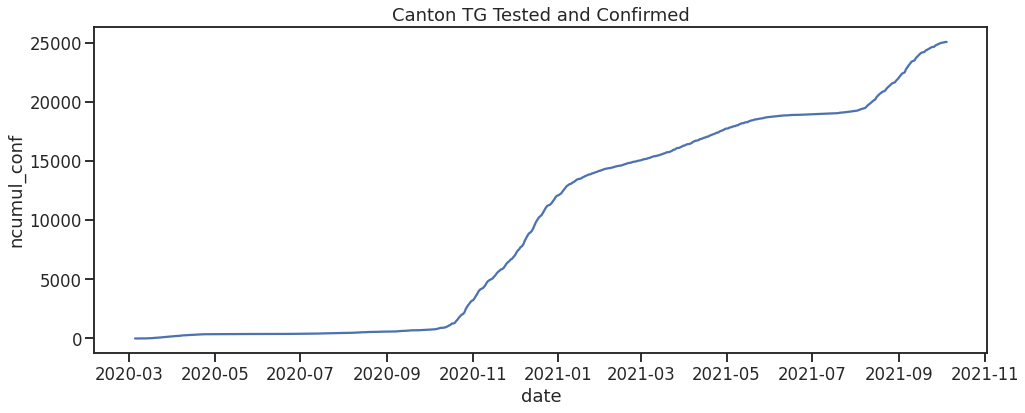

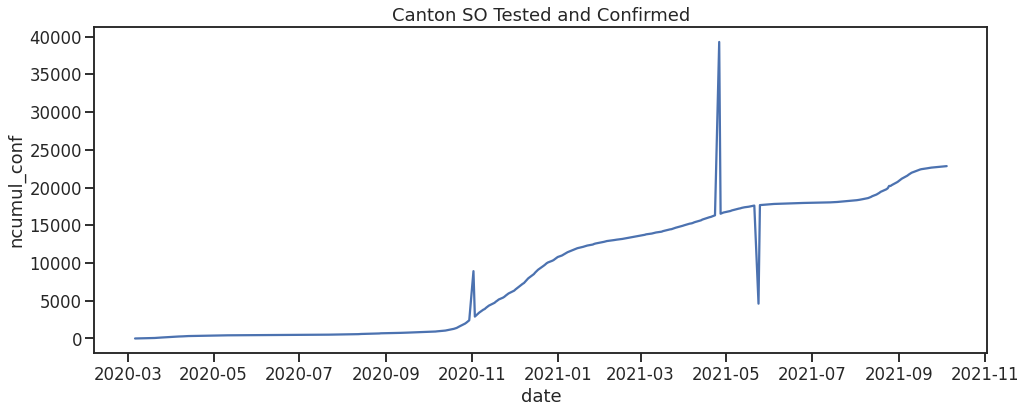

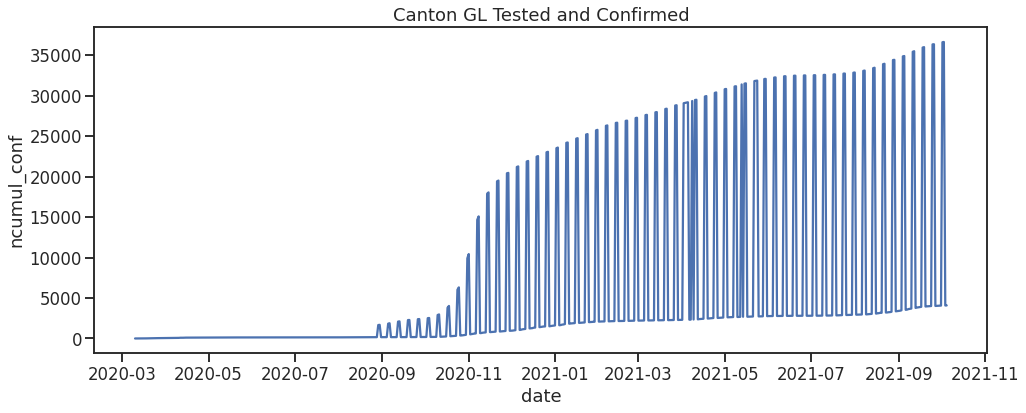

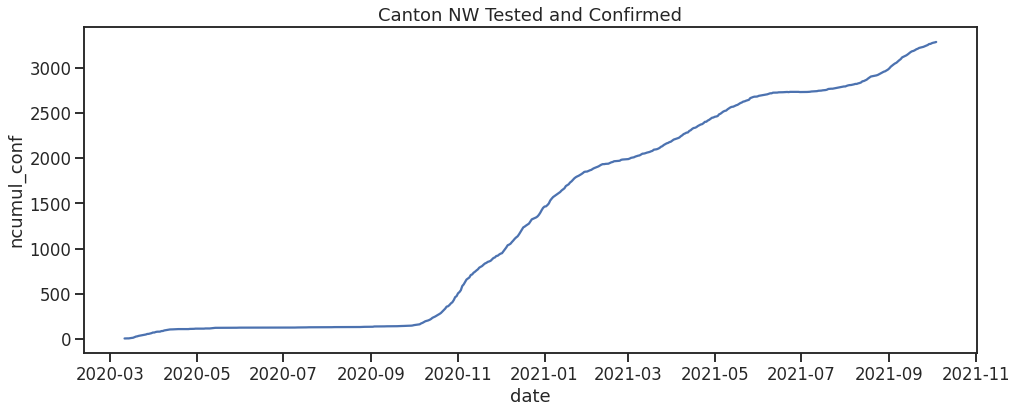

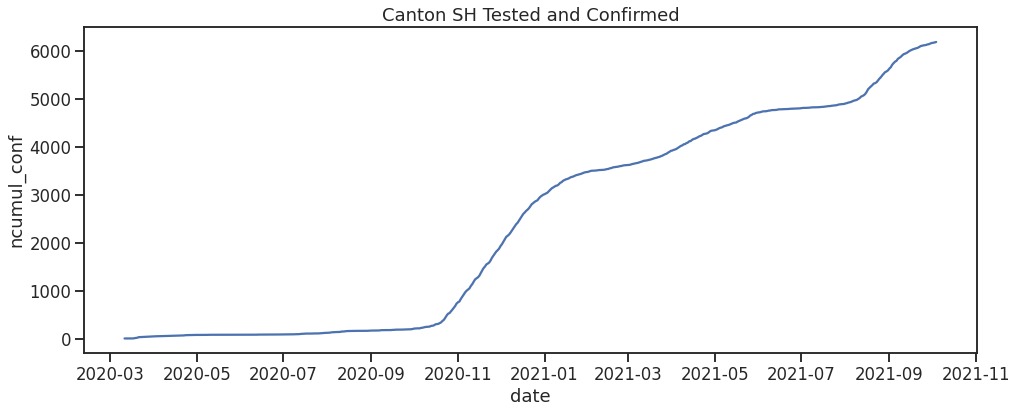

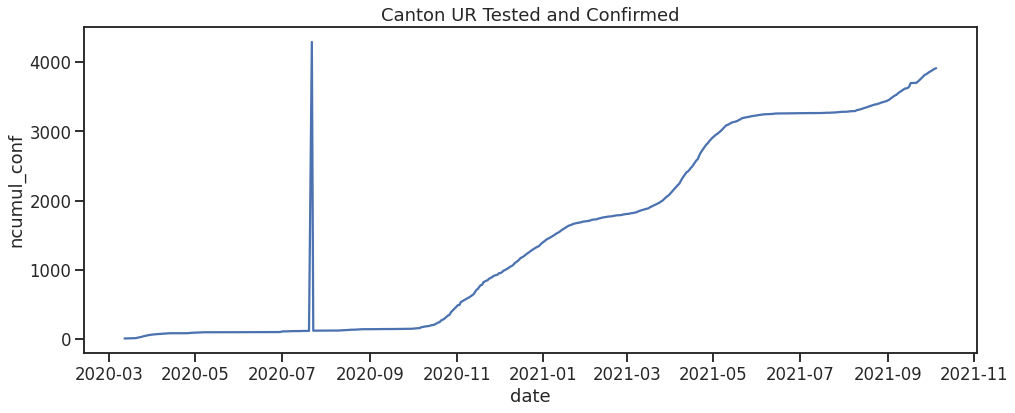

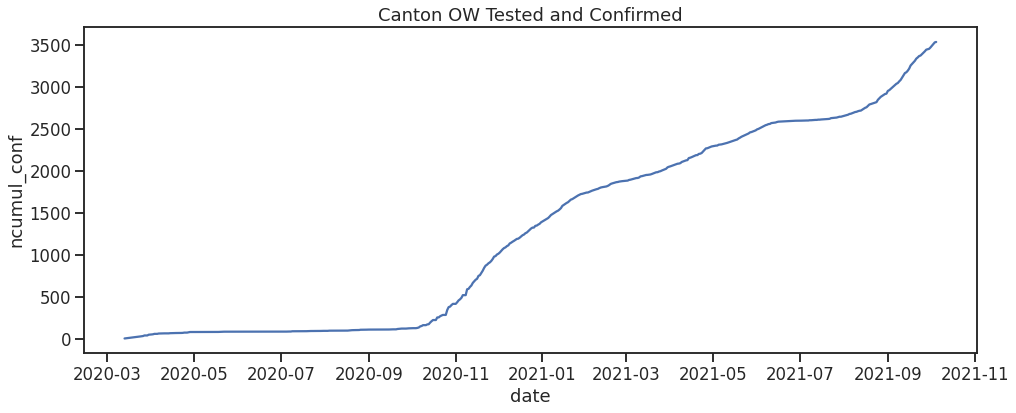

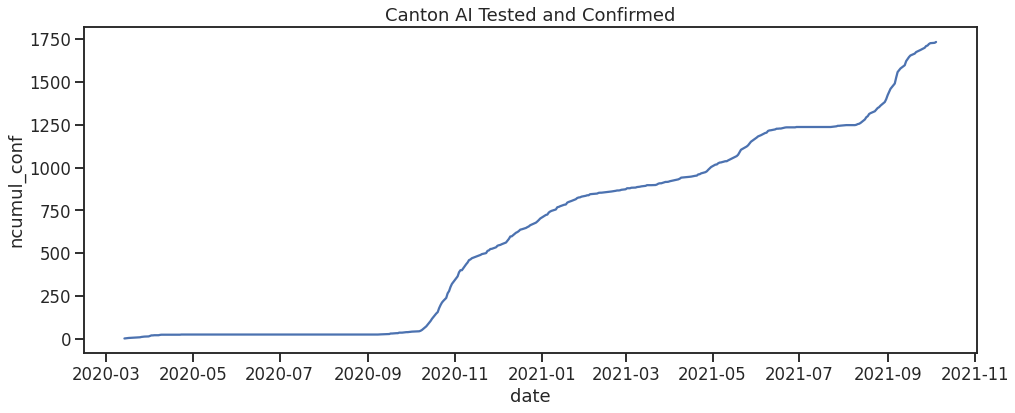

In [93]:
plt.figure(figsize=(16,6))
plt.title("Switzerland Confirmed Cases".format(canton))
sns.lineplot(data=df_cases.loc[:,'CH_total'])

for canton in cantons:
    plt.figure(figsize=(16,6))
    plt.title("Canton {} Tested and Confirmed".format(canton))
    sns.lineplot(data=df_cases.loc[(df_cases.cantons == canton),'ncumul_conf'])



#Vaud Case Study

<AxesSubplot:title={'center':'Vaud Tested and Confirmed'}>

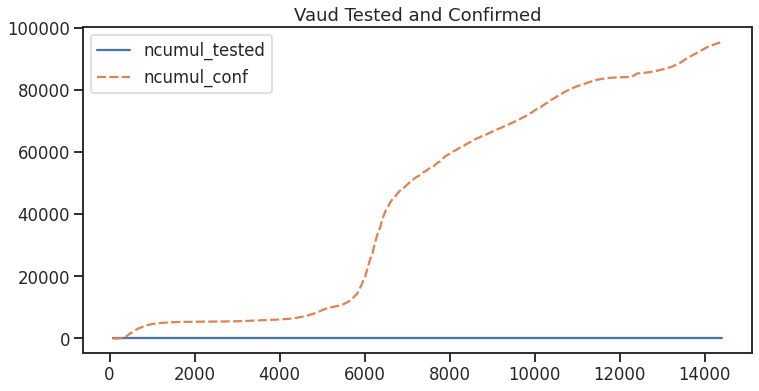

In [36]:
df_cases_vd=df_cases.loc[(df_cases.cantons == 'VD')]
plt.figure(figsize=(12,6))
plt.title('Vaud Tested and Confirmed')
sns.lineplot(data=df_cases_vd)


It shows that VD doesn't report any testing data

,date,cantons,ncumul_tested,ncumul_conf
12140,2021-06-23,VD,0.0,84281.0
12167,2021-06-24,VD,0.0,84293.0
12193,2021-06-25,VD,0.0,84299.0
12218,2021-06-26,VD,0.0,84301.0
12239,2021-06-27,VD,0.0,84306.0
12261,2021-06-28,VD,0.0,84322.0
12286,2021-06-29,VD,0.0,84327.0
12407,2021-07-04,VD,0.0,85419.0
12574,2021-07-11,VD,0.0,85625.0
12740,2021-07-18,VD,0.0,85948.0


In [267]:
#Visualization of Total Case
df_cases['CH']=
for canton in cantons:
    total = df_cases['date'].ncumul_tested

In [227]:
#Canton Testing
df_cases_cantons=df_cases.groupby(['cantons','date'])
df_cases_cantons.head()

,cantons,ncumul_tested,ncumul_conf
date,,,
2020-01-01,GE,0.0,1.0
2020-01-02,GE,0.0,1.0
2020-01-03,GE,0.0,1.0
2020-01-04,GE,0.0,1.0
2020-01-05,GE,0.0,5.0
...,...,...,...
2021-10-05,SZ,45004.0,15556.0
2021-10-05,TG,45004.0,25117.0
2021-10-05,BS,45004.0,16186.0


In [224]:
#Canton Confirmed
print(df_cases.groupby('cantons').ncumul_conf.agg([len, min, max]).sort_values(by='min', ascending=False))

         len  min       max
cantons                    
NW       573  4.0    3290.0
ZH       587  2.0  139938.0
AI       361  2.0    1735.0
UR       386  2.0    4296.0
GR       587  2.0   16605.0
VS       585  1.0   42712.0
VD       501  1.0   95606.0
TG       580  1.0   25117.0
SZ       565  1.0   15556.0
SO       405  1.0   39281.0
SH       573  1.0    6195.0
SG       582  1.0   54004.0
OW       475  1.0    3539.0
AG       587  1.0   59420.0
LU       572  1.0   36785.0
JU       586  1.0    8229.0
GL       544  1.0   36629.0
GE       644  1.0   67290.0
BS       587  1.0   16186.0
BE       583  1.0   80270.0
AR       300  1.0  138687.0
NE       583  1.0   19708.0
FR       583  0.0   36629.0
FL       584  0.0    3451.0
TI       530  0.0   36124.0
BL       589  0.0   22842.0
ZG       585  0.0   10443.0


<AxesSubplot:title={'center':'Vaud Tested and Confirmed'}, xlabel='date'>

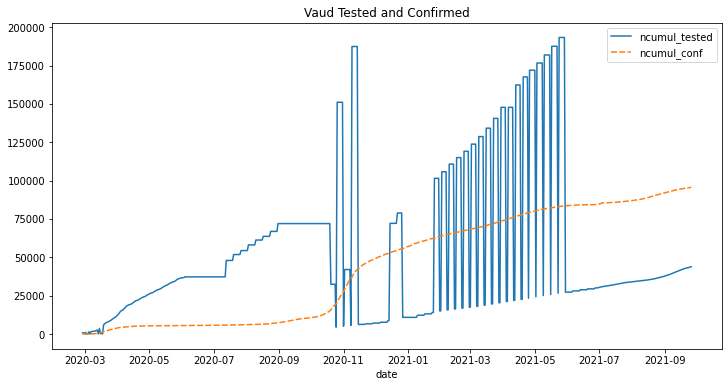

In [228]:
#Vaud Analysis
df_cases_vd=df_cases.loc[(df_cases.cantons == 'VD')]
plt.figure(figsize=(12,6))
plt.title('Vaud Tested and Confirmed')
sns.lineplot(data=df_cases_vd)